In [64]:
from utils import *

# libraries for Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

# libraries for features selectiona
# ANOVA F-test
from sklearn.feature_selection import f_classif
from sklearn import datasets

# library for standardize features
from sklearn.preprocessing import StandardScaler

# libraries for epsilon parameter
from sklearn.neighbors import NearestNeighbors

# libraries for Clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# libraries for Adjusted Rand Index
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# libraries for general utilities
import numpy as np 
from matplotlib import pyplot as plt

# global variables from work specifications
SEED = 42
set_seed(SEED)
NUMBER_FEATURES = 6
NEIGHBOURS = 5

In [65]:
def findEpsParams(features):
    
    neigh = NearestNeighbors(n_neighbors=NEIGHBOURS)
    nbrs = neigh.fit(features)
    distances, indices = nbrs.kneighbors(features)
    
    print(distances)

    distances = np.sort(distances, axis=0)[:,NEIGHBOURS-1]
    plt.plot(distances)
    plt.axhline(y=3.4, xmin=0, xmax=250, linestyle='-', c='red')
    plt.show()

    return 3.4

In [66]:
##
## DATASET LOADING
##

# create the loader class and load dataset and labels
loader = Loader().load()

# get dataset, labels, and dataset splitted by classes
dataset = loader.getDataset()
labels = loader.getLabels()
class_split_dataset = loader.getClassSplitDataset()



In [67]:
dataset.shape

(563, 2500)

In [68]:
##
## FEATURES CREATION
##

# extract 6 features wirh PCA
pca = PCA(n_components=NUMBER_FEATURES)
pca_dataset_embedded = pca.fit_transform(dataset)

# extract 6 features wirh t-sne
tsne = TSNE(n_components=NUMBER_FEATURES, method='exact')
tsne_dataset_embedded = tsne.fit_transform(dataset)

# extract 6 features wirh isomap
isomap = Isomap(n_components=NUMBER_FEATURES)
isomap_dataset_embedded = isomap.fit_transform(dataset)

# features concatenate (6,6,6) = 18 features
features = np.concatenate((pca_dataset_embedded,tsne_dataset_embedded, isomap_dataset_embedded), axis=1)

In [69]:
pca_dataset_embedded.shape

(563, 6)

In [70]:
# standardization
scaler = StandardScaler()
features_std = scaler.fit_transform(features)
labels = labels[:,1]

In [71]:
print(features_std.shape)
print(labels.shape)

(563, 18)
(563,)


In [72]:
##
## FEATURES EXTRACTION
##

# selection with ANOVA F-test
f,prob = f_classif(features_std, labels)
indexes = np.arange(len(f))
app = [ [i, ele] for i, ele in enumerate(f)]
app.sort(key = lambda app: app[1], reverse = True)
indexes = np.array([ int(a) for a in np.array(app)[:,0]])
print(indexes)
f = f[indexes]
print(f)
prob = prob[indexes]
print(prob)

[13  2  1 12  0 16 15 14 10  6  4 11  7  5 17  8  3  9]
[41.31820477 32.71839925 19.24821341 14.04786286 12.79637841  6.81730345
  5.7198292   5.37225413  5.20874744  3.52326974  3.43336257  3.13436264
  1.99106122  1.89895973  1.3927433   0.88030932  0.63172337  0.3459137 ]
[3.96454630e-24 1.70256366e-19 6.86097946e-12 7.69520113e-09
 4.25350548e-08 1.61480141e-04 7.35260521e-04 1.18712751e-03
 1.48683101e-03 1.48939918e-02 1.68207626e-02 2.51736599e-02
 1.14227316e-01 1.28643767e-01 2.44046422e-01 4.51028922e-01
 5.94769523e-01 7.92129373e-01]


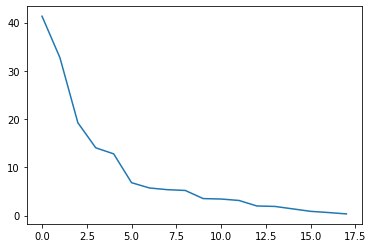

In [73]:
##
## FEATURES SELECTION
##

plt.plot(f)
plt.show()

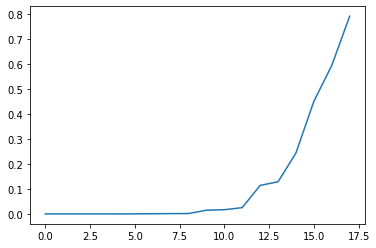

In [74]:
##
## FEATURES SELECTION
##

plt.plot(prob)
plt.show()

Classification accuracy without selecting features: 0.762
Classification accuracy after univariate feature selection: 0.857


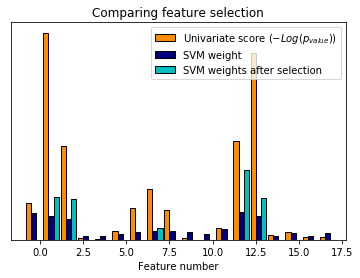

In [75]:
# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

feat = features_std[labels!=0]
lbs = labels[labels!=0]

k_selection = 5

# Some noisy data not correlated
#E = np.random.RandomState(42).uniform(0, 0.1, size=(feat.shape[0], 20))

# Add the noisy data to the informative features
#feat = np.hstack((feat, E))

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        feat, lbs, stratify=lbs, random_state=0
)

selector = SelectKBest(f_classif, k=k_selection)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(feat.shape[-1])
plt.bar(X_indices - .65, scores, width=.3,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

# #############################################################################
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .35, svm_weights, width=.3, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=k_selection), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.3, label='SVM weights after selection', color='c',
        edgecolor='black')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')


plt.show()

In [ ]:
##
##  CLUSTERING
##

# selecting manually the epsilon params for DBSCAN
eps = findEpsParams(features_std)

In [ ]:
# clustering with DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=NEIGHBOURS)
dbscan_labels = dbscan.fit_predict(features_std)

# clustering with K-MEANS
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(features_std)